<a href="https://colab.research.google.com/github/GingerSpacetail/family-heritage/blob/main/MB_Data_analysis_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimental and Syntetic data


## Preparation

### Import libraries

In [ ]:
#%pip install latexify-py #run if in Colab for the first time only
#if % not working, use ! instead

In [ ]:
#%pip install xlsxwriter #run if in Colab for the first time only

In [ ]:
#%pip install fitter  #run if in Colab for the first time only 
#to choose the best distribution

In [ ]:
#%pip install scipy # install SciPy #run if in Colab for the first time only 

In [ ]:
import statsmodels.stats.power as smp
from statsmodels.stats.power import TTestIndPower

import numpy as np
from numpy import array
from numpy import std, mean, sqrt

import pandas as pd

import fitter

import scipy as sp
from scipy.stats import levene,  shapiro, kstest, normaltest, chi2_contingency, kruskal, mannwhitneyu, ttest_ind, ttest_rel, f_oneway, wilcoxon, friedmanchisquare, pearsonr, spearmanr
from scipy.optimize import curve_fit
from scipy.special import boxcox, inv_boxcox

import statsmodels.api as sm
import pingouin as pg

import latexify
import xlsxwriter

import seaborn as sns
from statannotations.Annotator import Annotator

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

#from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import custom_functions

#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.activations import relu,linear
#from tensorflow.keras.losses import SparseCategoricalCrossentropy
#from tensorflow.keras.optimizers import Adam

#import logging
#logging.getLogger("tensorflow").setLevel(logging.ERROR)

### Import your data

If you work locally, move data file to the the repocitory folder or specify the path

In [ ]:
data_example = pd.read_excel('RFU values for Giulia.xlsx', sheet_name='Sheet1', header=[0,1], index_col=0)

In [ ]:
#file_path = 'path/to/your/file.xlsx'

file_name = "annual_CDC_survey_data_250k_adults_related_to_their_health_status.xlsx"
demo_dataset= pd.read_excel(file_name, sheet_name='heart_2020')

If in Google colab, you upload data from your computer or mount your google drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')


## Data exploration

Have a look at what has been imported (optional)

In [ ]:
demo_dataset

Make an array of the feature names from your columns (e.g. treated vs untreated, human vs model, different organs or tissues etc.)
In our case - Sex, Body mass index, Smoking status, etc.

In [ ]:
feature_names = np.array(demo_dataset.columns)
feature_names

### Descriptive statistics

#### Sample size, mean, standard deviation

The cell below make simple arithmetics for each feature

In [ ]:
custom_functions.describe_data(demo_dataset)

### Explore the data with some plots



#### Error bar plot

In [ ]:
sns.pointplot(y=demo_dataset['BMI'], x=demo_dataset['SleepTime'], errorbar='ci', capsize=0.1)

#### Violin plot (if more that 3 data point)
to see means, quantiles and develop intuition about difference btw samples (e.g. who had stroke and who had not)

Selecting only numerical columns

In [ ]:
numeric_features = demo_dataset.select_dtypes(include=['float', 'int']).columns 
print(numeric_features)


In [ ]:
#this loop goes through all features and display a violin plot for each numeric feature

for i, col in enumerate(numeric_features):
  violin_plot = go.Figure()
  violin_plot.add_trace(go.Violin(x=demo_dataset['Stroke'],
                           y=demo_dataset[col],
                           line_color=px.colors.qualitative.Plotly[i], #that's the colorcode for the line
                           name=col,
                           #points='all', #option to show all points
                           pointpos=0))
  violin_plot.update_layout(violinmode='group', title_text=col, xaxis_title='Stroke', yaxis_title=col)
  violin_plot.show()

In [ ]:

#this loop goes through all cell lines and plot
for i, col in enumerate(numeric_features):
  fig = px.violin(
      demo_dataset,
      x = 'Stroke',
      y = col,
      title= col,
      color=demo_dataset['Stroke'],
      #points='all',
      box=True)
  fig.show()




#### Histogam (the more datapoint the better)
to have a look at the distribution (looks better with more samples)

In [ ]:
for i in numeric_features:
  fig = px.histogram(
      demo_dataset,
      x=i,
      nbins=50,
      title = i)
  fig.show()

### Distribution
We will fit the best distribution and check stat assumptions for statisticak tests:

normality and homoscedasticity

#### Example on generated data

In [ ]:
from scipy import stats
synthetic_data = stats.gamma.rvs(3, loc=1.5, scale=2, size=1000)

In [ ]:
#the list of all distributions avalible for test
from fitter import get_distributions
get_distributions()

In [ ]:
#get sub set of common distributions
from fitter import get_common_distributions
get_common_distributions()

In [ ]:
import fitter
f = fitter.Fitter(synthetic_data)

# just a trick to use only 10 distributions instead of 80 to speed up the fitting
#f.distributions = f.distributions[0:10] + ['gamma']

# another trick to use only common distributions instead of 80 to speed up the fitting
f.distributions = get_common_distributions()

# fit and plot
f.fit()
f.summary()
# may take some time since by default

Output the best fitted distribution and its parameters

In [ ]:
#Return best fitted distribution and its parameters
#a dictionary with one key (the distribution name) and its parameters

f.get_best(method='sumsquare_error')

#### Find distribution of our demo data

In [ ]:
fit_demo = fitter.Fitter(demo_dataset['BMI'],
                  distributions = get_common_distributions())

# we'll use only common distributions instead of 80 to speed up the fitting


# fit and plot
fit_demo.fit()
fit_demo.summary()
# may take some time


In [ ]:
fit_demo.get_best(method='sumsquare_error')

In [ ]:
mean_BMI, std_BMI = fit_demo.fitted_param['norm']

print('estimated mean:', mean_BMI)
print('estimated standard deviation:', std_BMI)

### Test for normality (Shapiro-Wilk test)

For sample size <50

The Null hypothesis that the data are normally distributed (mean = 0, standard deviation = 1)

If the p-value is less than 5%, then the distribution in question is significantly different from a normal distribution

In [ ]:
# Shapiro-Wilk test for normality
statistic_gamma, p_value_gamma = shapiro(synthetic_data)

# the result
print("Shapiro-Wilk test statistic:", statistic_gamma)
print("If p-value is less than 0.05, we reject normality:", p_value_gamma)


### Test for normality (Lilliefors test)

The Null hypothesis that the data are sampled from a Gaussian distribution (mean and standard deviation can be any).

If the p-value is less than 5%, we reject the hypothesis that the data are normally distributed.

In [ ]:
statistics_BMI, p_value_BMI = sm.stats.lilliefors(demo_dataset['BMI'])

print("Lilliefors test statistic:", statistics_BMI)
print("If p-value is less than 0.05, we reject normality:", p_value_BMI)

In [ ]:
x = np.random.normal(mean_BMI, std_BMI, 10000)
res_norm, p_norm = sm.stats.lilliefors(x)


print("If p-value is more than 0.05, we assume normality:", p_norm)

### Test for homoscedactisity

The [Levene test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html#scipy.stats.levene) tests the null hypothesis that all input samples are from populations with equal variances. Works even with non-normally distributed data

In [ ]:
# Perform Levene's test for homoscedasticity
statistic, p_value = levene(demo_dataset['BMI'][demo_dataset['Stroke'] == 'Yes'], 
                            demo_dataset['BMI'][demo_dataset['Stroke'] == 'No'], 
                            center='median') #Recommended for skewed (non-normal) distributions

# Print the test statistic and p-value
print("Levene's test statistic:", statistic) #The value of the statistic tends to be high when there is a large difference in variances
print("p-value:", p_value) #if the p-value is less than 0.05, the variances are not equal


## Data preprocessing (normalization)

| Distribution| Transformation | Example |
|----------|----------|----------|
|   Normal  |   nothing  | 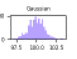 |
|   Lognormal  |   $\ln(variable)$ or The Box-Cox transformation |  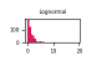 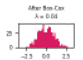  |
|   Gamma  |  $\sqrt[3]{variable}$  |   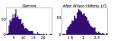  |
|   Chi2  |  The Box-Cox transfromation  |   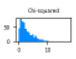 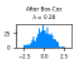  |
|   Exponential, Weibull |  The Box-Cox transfromation  |   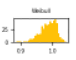 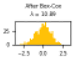 |
|   Cauchy |  Pretend you didn't see it |  No exact mean. Extreme events, such as annual maximum one-day rainfalls and river discharges, value-at-risk in finance |


### The Box-Cox transformation

$$
y = \begin{cases}
\frac{x^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0 \\
\ln(x) & \text{if } \lambda = 0 \\
\end{cases}
$$
  

In [ ]:
demo_dataset['BMI_transformed'] = boxcox(demo_dataset['BMI'], 0.5) #lambda varies from -5 to 5

In [ ]:
fit_BMI_transformed = fitter.Fitter(demo_dataset['BMI_transformed'],
                    distributions = get_common_distributions())

# fit and plot
fit_BMI_transformed.fit()
fit_BMI_transformed.summary()
# may take some time

In [ ]:
res_tr, p_tr = sm.stats.lilliefors(demo_dataset['BMI_transformed'])

print("If p-value is less than 0.05, we reject normality:", p_tr)

In [ ]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Histogram(x=demo_dataset['BMI'], 
                           name='BMI'), 
              row=1, col=1)

fig.add_trace(go.Histogram(x=demo_dataset['BMI_transformed'], 
                           name='BMI Transformed'), 
              row=1, col=2)

fig.update_layout(title='Histogram of BMI and Transformed BMI',
                  xaxis_title='BMI',
                  yaxis_title='Count')

fig.show()


### Cubic root transform

In [ ]:

# on generated data that follows a gamma distribution
cubic_root_transformed = np.cbrt(synthetic_data)


In [ ]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Histogram(x=synthetic_data, 
                           name='Gamma'), 
              row=1, col=1)

fig.add_trace(go.Histogram(x=cubic_root_transformed, 
                           name='Gamma Transformed'), 
              row=1, col=2)

fig.update_layout(title='Histogram of Gamma and Transformed Gamma',
                  xaxis_title='X',
                  yaxis_title='Count')

fig.show()

Test for normality

In [ ]:
res_g, p_g = sm.stats.lilliefors(cubic_root_transformed)

print("If p-value is less than 0.05, we reject normality:", p_g)

## Hypotesis testing

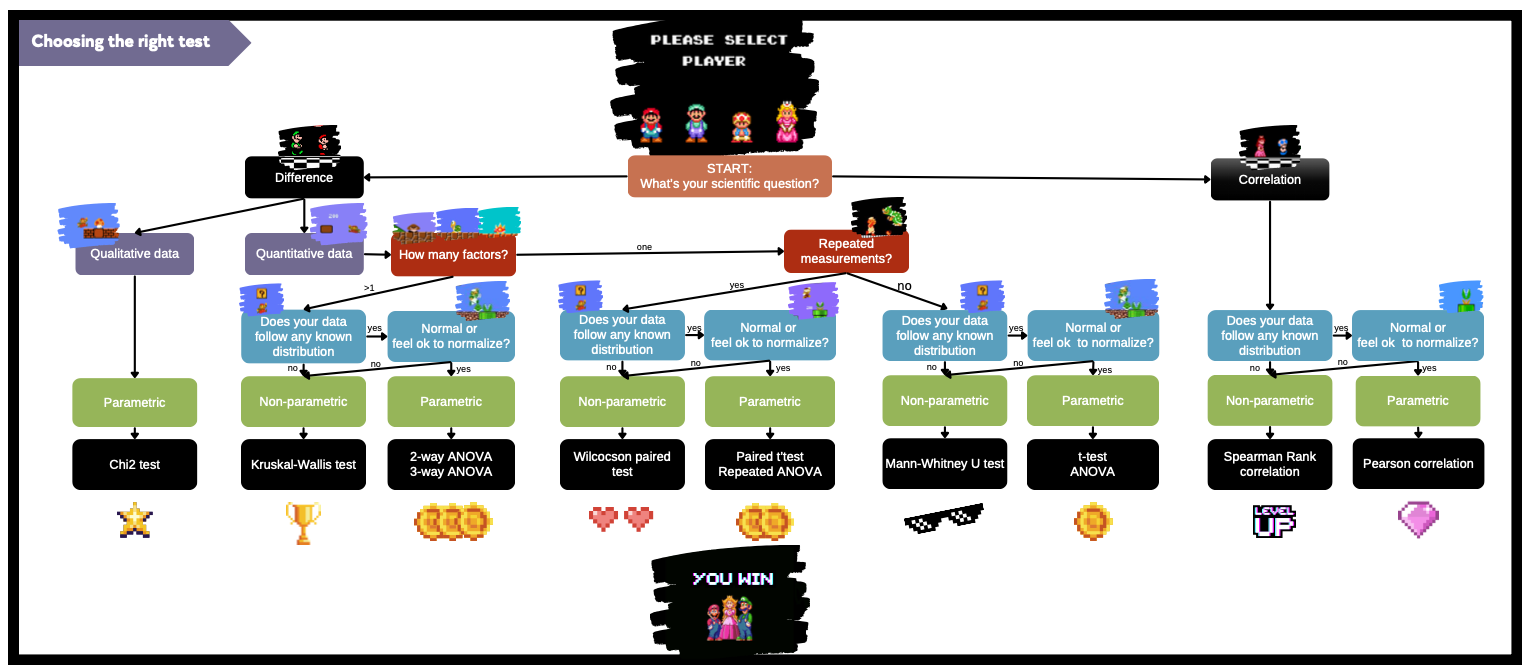

### Chi2 test

In [ ]:
# contingency table
contingency_table = pd.crosstab(demo_dataset['Stroke'], demo_dataset['PhysicalActivity'])

# the chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# result
print("Chi-square test statistic:", chi2)
print("If p-value is less than 0.05, the variables are dependent. P-value:", p_value) 

#print("Degrees of freedom:", dof)
#print("Expected frequencies:", expected)


### Kruskai-Wallis test

H0: there is no difference between the groups

If p-value less than 0.05, then there is at least two groups that differ

In [ ]:
# Kruskal-Wallis test
kw_results = pg.kruskal(demo_dataset, dv='BMI', between='Diabetic')

# Kruskal-Wallis test results
print("Kruskal-Wallis Test Results:")
print(kw_results)

In [ ]:

# post-hoc pairwise comparisons
posthoc_results = pg.pairwise_gameshowell(demo_dataset, dv='BMI', between='Diabetic')


# post-hoc pairwise comparison results
print("\nPost-Hoc Pairwise Comparison Results:")
print(posthoc_results)



In [ ]:
# Filtering for pairs with a significant difference
significant_pairs = posthoc_results[posthoc_results['pval'] < 0.05]

# Print the significant pairs
print("Pairs with a significant difference:")
print(significant_pairs)
print('Number of pairs:', len(significant_pairs))

In [ ]:
# all_pairs = posthoc_results[['A', 'B']].values.tolist()
# print(all_pairs)
# print(len(all_pairs))



# ax = sns.violinplot(data=demo_dataset, 
#                  x='Diabetic', 
#                  y='BMI')

# annotator = Annotator(ax, all_pairs, data=demo_dataset, x='Diabetic', y='BMI')
# annotator.configure(test='kruskal', comparisons_correction="Bonferroni", text_format='star', loc='outside') #Kruskal-Wallis test using 
# test_results = annotator.apply_and_annotate()


In [ ]:
# plt.savefig("Significance {}.png".format('BMI'), bbox_inches='tight')

### ANOVA test

In [ ]:
# ANOVA test
group1 = demo_dataset[demo_dataset['Diabetic'] == 'Yes']['BMI']
group2 = demo_dataset[demo_dataset['Diabetic'] == 'No']['BMI']
f_statistic, p_value = f_oneway(group1, group2)

# ANOVA results
print("F-statistic:", f_statistic)
print("p-value:", p_value)


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# test
tukey_results = pairwise_tukeyhsd(demo_dataset['BMI'], demo_dataset['Diabetic'])

# test results
print("Tukey's HSD Test Results:")
print(tukey_results)


### Mann-Whitney U test

In [ ]:
# Mann-Whitney U test
group1 = demo_dataset[demo_dataset['Stroke'] == 'Yes']['BMI']
group2 = demo_dataset[demo_dataset['Stroke'] == 'No']['BMI']
statistic, p_value = mannwhitneyu(group1, group2)

print("Mann-Whitney U test conditioned by 'Stroke'")
print("Test statistic:", statistic)
print("If p-value is less than 0.05 then there is difference between the groups:", p_value)



### T-test


In [ ]:
# Define two groups of data

# Perform the T-test
t_statistic, p_value = ttest_ind(group1, group2)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

### Wilcocson paired test

In [ ]:
sample1 = group1
sample2 = group1*1.1
# the Wilcoxon signed-rank test
statistic, p_value = wilcoxon(sample1, sample2)

# Print the results
print("Wilcoxon signed-rank test statistic:", statistic)
print("P-value:", p_value)


### Paried t-test

In [ ]:
# Perform the paired t-test
t_statistic, p_value = ttest_rel(sample1, sample2)

# Print the results
print("Paired t-test statistic:", t_statistic)
print("P-value:", p_value)


### Repeated ANOVA

In [ ]:
sample1 = sample1
sample2 = sample2
sample3 = sample1*2

# Perform the repeated measures ANOVA
statistic, p_value = friedmanchisquare(sample1, sample2, sample3)

# Print the results
print("Friedman chi-square statistic:", statistic)
print("P-value:", p_value)


### Pearson corrlation

In [ ]:
#Pearson corrlation
correlation, p_value = pearsonr(demo_dataset['BMI'], demo_dataset['SleepTime'])


print("Pearson correlation coefficient:", correlation)
print("p-value:", p_value)


### Spearman correlation

In [ ]:
from scipy.stats import spearmanr

# Spearman correlation 
correlation, p_value = spearmanr(demo_dataset['BMI'], demo_dataset['PhysicalHealth'])

print("Spearman correlation coefficient:", correlation)
print("p-value:", p_value)


## Power analysis

Statistical Power calculations for a t-test for two independent sample

### Effect size can be measured by e.g. Cohen distance between the groups


| Effect size | d | Reference|
|----------|----------|----------|
|   Very small  |   0.01    |   [New Effect Size Rules of Thumb ](https://doi.org/10.22237%2Fjmasm%2F1257035100) |
|   Small  |   0.20 |   [Statistical Power Analysis for the Behavioral Sciences](https://books.google.com/books?id=2v9zDAsLvA0C&pg=PP1) |
|   Medium  |   0.50    |[Statistical Power Analysis for the Behavioral Sciences](https://books.google.com/books?id=2v9zDAsLvA0C&pg=PP1)|
|   Large 	|   0.80 	|[Statistical Power Analysis for the Behavioral Sciences](https://books.google.com/books?id=2v9zDAsLvA0C&pg=PP1)|
|   Very large 	|1.20 	|[New Effect Size Rules of Thumb ](https://doi.org/10.22237%2Fjmasm%2F1257035100)|
|Huge 	|2.0 	|[New Effect Size Rules of Thumb ](https://doi.org/10.22237%2Fjmasm%2F1257035100)|¶

We can compute a power analysis using functions from the statsmodels.stats.power package.



### Theory
The goal to determine a difference in the mean between two groups using an independent samples t-test.

Let’s calculate an effect size of Cohen’s d
$$ d = \frac {(M_2 - M_1)} {SD_{pooled}} $$
where $M_i$ is mean for an $i$-th sample,

and $SD_{pooled}$ is a pooled standard deviation $$SDpooled = \sqrt{\frac{(n_1 - 1) * SD_1^2 + (n_2 - 1) * SD_2^2} {n_1 + n_2 - 2}}$$  


Cohen’s D , or standardized mean difference, is one of the most common ways to measure effect size. An effect size is how large an effect is. For example, medication A has a larger effect than medication B. While a p-value can tell you if there is an effect, it won’t tell you how large that effect is.

Cohen’s D specifically measures the effect size of the difference between two means
### Examples
![Cohen's distance: source statisticshowto.com](https://scientificallysoundorg360.files.wordpress.com/2017/07/cohen_example-e1499923427851.png?w=860)

If in Colab uncomment the next cell to be able to calculate the cohen distance

In [ ]:
# def cohen_d(x,y):
#     #correct if the population S.D. is expected to be equal for the two groups.
#     nx = len(x)
#     ny = len(y)
#     dof = nx + ny - 2
#     return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)


Let's have a look at our data

In [ ]:
fig = px.histogram(
    demo_dataset,
    x='BMI',
    color='Stroke',
    nbins=100,
    barmode='overlay',
    histnorm='probability density',
    title = 'BMI distribution')
fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Violin(x = demo_dataset['Sex'][ demo_dataset['Stroke'] == 'Yes' ],
                        y = demo_dataset['BMI'][ demo_dataset['Stroke'] == 'Yes' ],
                        legendgroup='Yes', scalegroup='Yes', name='Yes',
                        side='negative',
                        line_color='blue')
             )
fig.add_trace(go.Violin(x = demo_dataset['Sex'][ demo_dataset['Stroke'] == 'No' ],
                        y = demo_dataset['BMI'][ demo_dataset['Stroke'] == 'No' ],
                        legendgroup='No', scalegroup='No', name='No',
                        side='positive',
                        line_color='orange')
             )
fig.update_traces(meanline_visible=True,
                  #points='all',  # show all points
                  #jitter=0.05,  # add some jitter on points for better visibility
                  scalemode='count') #scale violin plot area with total count)
fig.update_layout(violingap=0.5, violinmode='overlay',
                  title_text='BMI distribution by Stroke')
fig.show()

Calculate the Cohen distanse between the groups

In [ ]:
group_distance = custom_functions.cohen_d(demo_dataset.loc[demo_dataset['Stroke'] == 'Yes', 'BMI'], demo_dataset.loc[demo_dataset['Stroke'] == 'No', 'BMI'])

group_distance_female = custom_functions.cohen_d(demo_dataset.loc[(demo_dataset['Stroke'] == 'Yes') & (demo_dataset['Sex'] == 'Female'), 'BMI'], demo_dataset.loc[(demo_dataset['Stroke'] == 'No') & (demo_dataset['Sex'] == 'Female'), 'BMI'])
group_distance_male = custom_functions.cohen_d(demo_dataset.loc[(demo_dataset['Stroke'] == 'Yes') & (demo_dataset['Sex'] == 'Male'), 'BMI'], demo_dataset.loc[(demo_dataset['Stroke'] == 'No') & (demo_dataset['Sex'] == 'Male'), 'BMI'])

print('Cohen distance between the groups is', group_distance.round(2))
print('Cohen distance between the female groups is', group_distance_female.round(2))
print('Cohen distance between the male groups is', group_distance_male.round(2))

### Calculate the sample size

We wish to have 80% power to find the effect if it exists. We can compute the sample size needed for adequate power using the TTestIndPower() function:

In [ ]:
power_analysis = smp.TTestIndPower()
sample_size_female = power_analysis.solve_power(effect_size = group_distance_female, power=0.8, alpha=0.05)
sample_size_male = power_analysis.solve_power(effect_size = group_distance_male, power=0.8, alpha=0.05)

print("We need {size:.0f} obesrvations to detect difference in female population".format(size = sample_size_female))
print("We need {size:.0f} obesrvations to detect difference in male population".format(size = sample_size_male))

### General observations on power, sample size, and significance

A plot showing how many samples we need to achieve the desired power of the test with the given statistical significance $\alpha$. It's nice to have 80% power

In [ ]:
# parameters for power analysis
effect_sizes = array([0.10, 0.40, 0.60, 0.8])
sample_sizes = array(range(5, 100))
significance = 0.05 #change this number to play with significance level

# calculate power curves from multiple power analyses

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel('Power of a test')
fig = power_analysis.plot_power(
    dep_var='nobs', #which variable is used for the horizontal axis
    nobs=sample_sizes, #number of observations
    effect_size=effect_sizes, #effect size
    alpha=significance, #significance level
    ax=ax, #reuse axis from plt
    title='Power of a t-test\n$\\alpha ={a}$ depending on sample size'.format(a = significance))

## Save what is needed

In [ ]:
## save to xlsx file
writer = pd.ExcelWriter('Data analysis.xlsx', engine='xlsxwriter')
demo_dataset.to_excel(writer, 'Sheet1')
writer.close()